# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)
warnings.filterwarnings('ignore')


Интересное наблюдение: при попытке использовать pd.read_csv() сегда вылезала ошибка (Error tokenizing data.), причем методы, описанные в сети не помогали, но как только я применил pd.read_excel(), проблема сразу же отпала.

In [34]:
data = pd.read_excel('geo_comment.xlsx')
data.head()

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


Создадим отдельные DF, содержащие только положительные и только отрицательные голоса (попутно, убив ненужные колонки):

In [58]:

data_p = data[data['comment_class']==1].drop(['comment_class', 'Unnamed: 0', 'multiplier'], axis=1) #положительные голоса 
data_n = data[data['comment_class']!=1].drop(['comment_class', 'Unnamed: 0', 'multiplier'], axis=1) #отрицательные голоса 
data_p.head()

,x,y,comment
28,37.588916,55.741982,Не был осведомлен о месте и времени проведения...
45,37.589311,55.734273,Голосую за зону развития по адресу: Новодевичи...
46,37.558526,55.728758,Голосую за зону развития по адресу: Новодевичи...
47,37.566431,55.731794,Голосую за зону развития по адресу: Новодевичи...
61,37.589311,55.734273,Голосую за зону развития по адресу: Новодевичи...


Выводим все в картинки

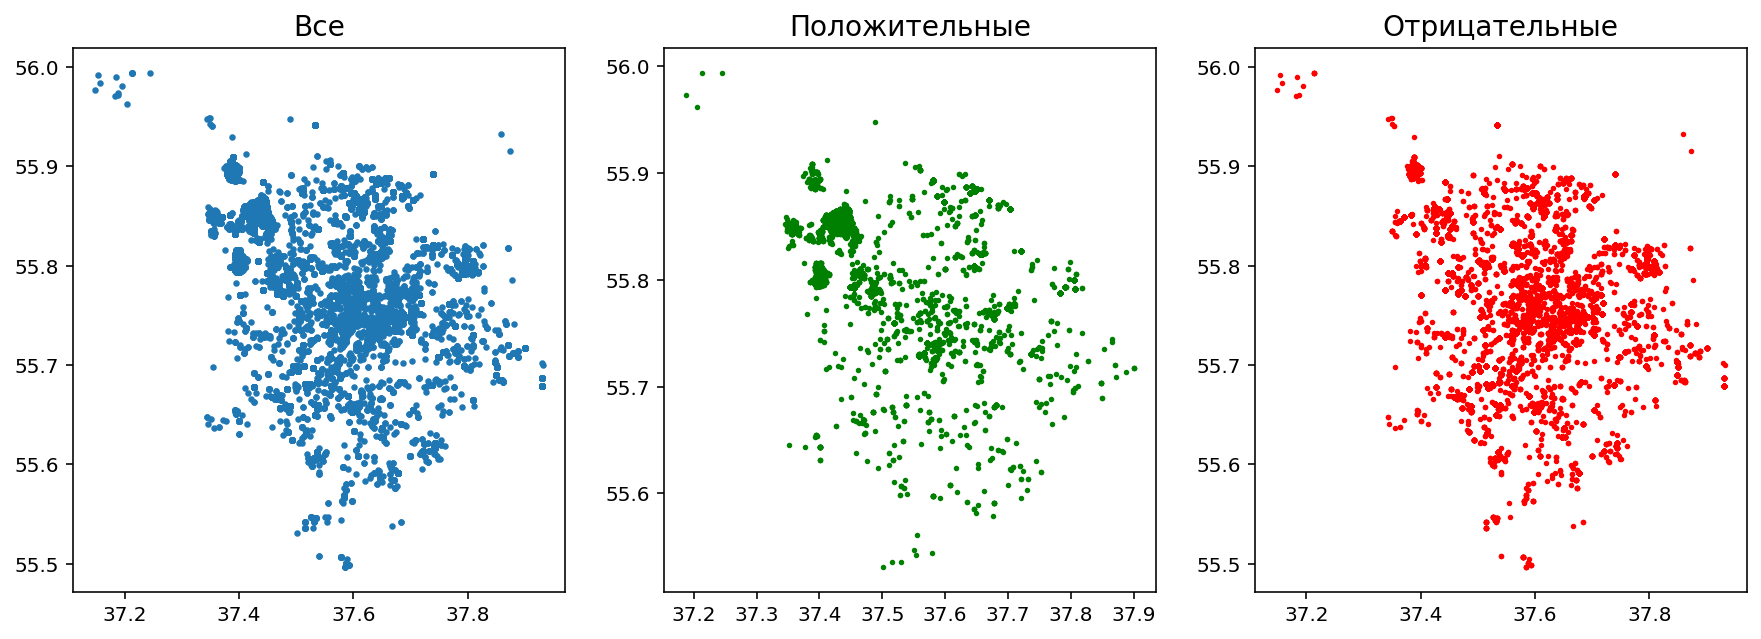

In [53]:
# выводим общие данные на карту без разбивки и с разбивкой на положительные и отрицательные голоса

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5)) # количество строк и колонок, а также их размер

ax1.scatter(x=data.x, y=data.y, s=5)
ax2.scatter(x=data_p.x, y=data_p.y, s=3, color='g')
ax3.scatter(x=data_n.x, y=data_n.y, s=3, color='r')

titles = ["Все", "Положительные", "Отрицательные"]
colors = ["b", "g", "r"]
all_data = [data, data_p, data_n]

for number, title in zip (fig.axes, titles):
    number.set_title(title, fontsize=14)

Подбираем число кластеров

In [59]:
from sklearn.cluster import KMeans, DBSCAN

Для начала уберем все лишнее из основного  DF, оставив только геоданные. Текстовые комментарии также надо убрать. Пока.

In [60]:
data_clear = data[data['comment_class']==1].drop(['comment_class', 'Unnamed: 0', 'multiplier', 'comment'], axis=1) #все голоса без лишних колонок

In [61]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_clear, )
    k_inertia.append(clf_kmeans.inertia_)

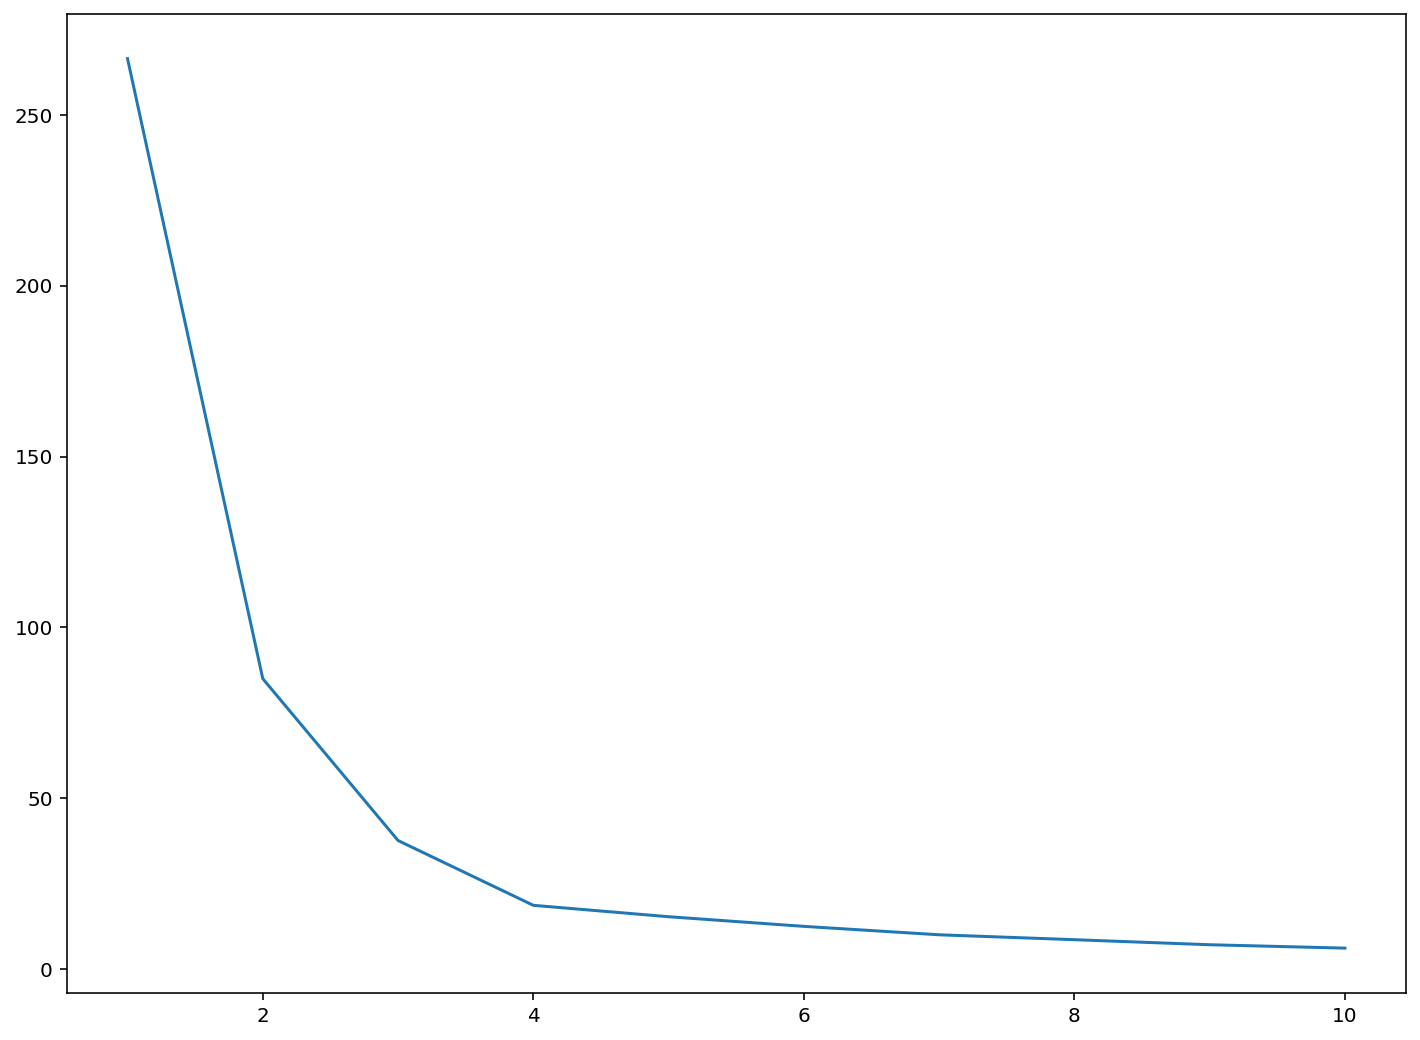

In [65]:
plt.plot(ks, k_inertia)

In [66]:
diff = np.diff(k_inertia)

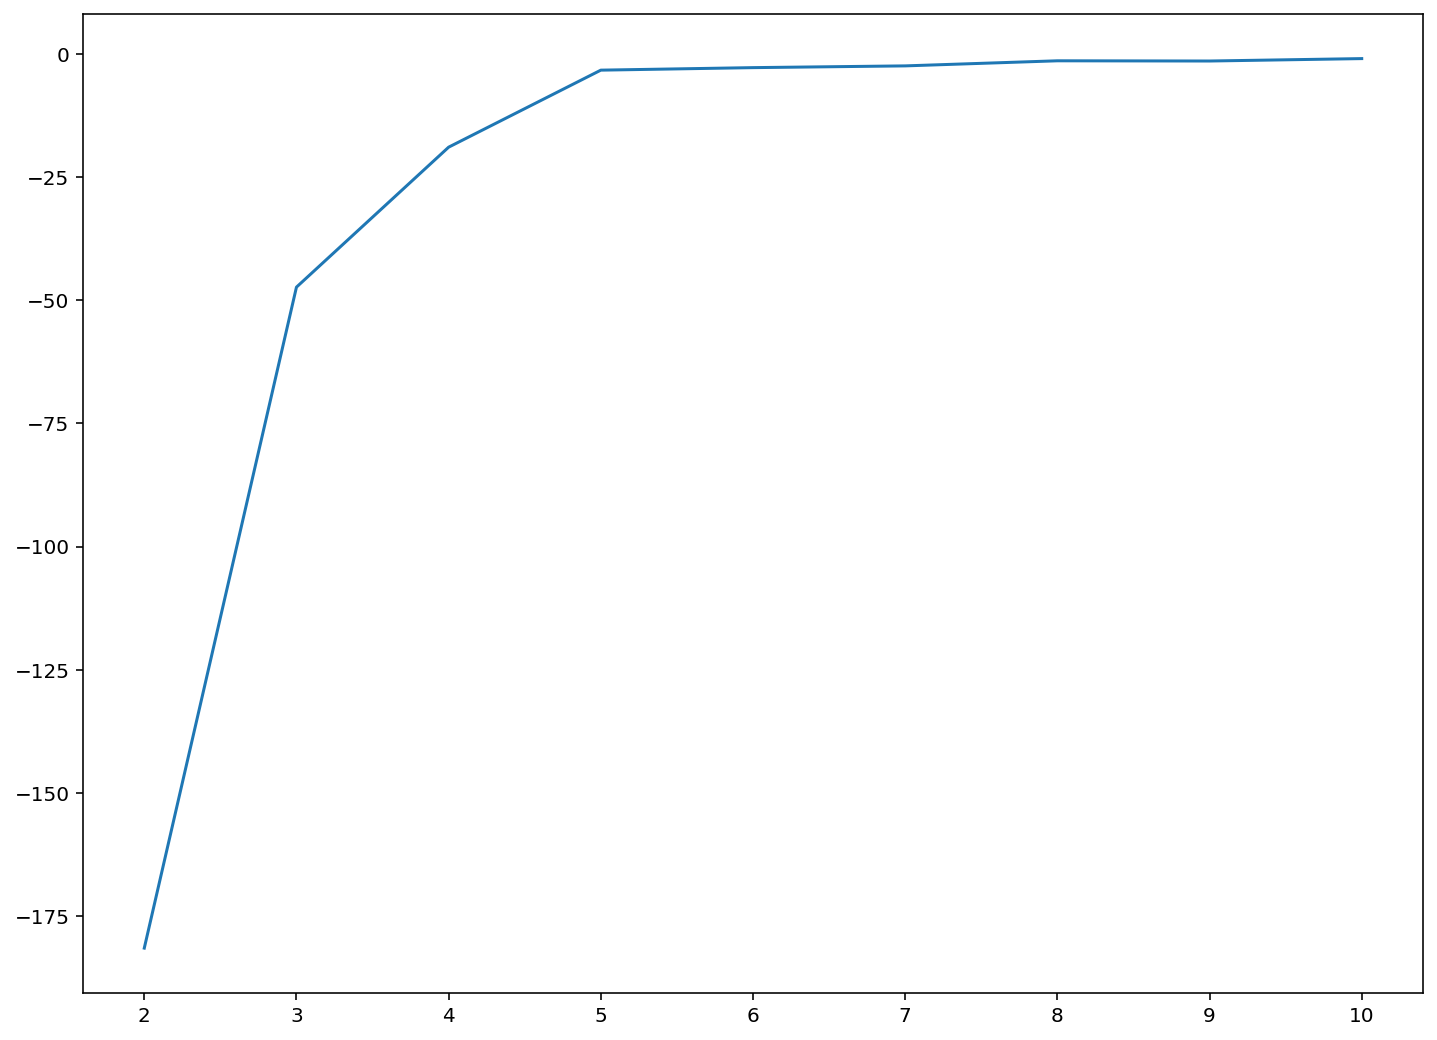

In [67]:
plt.plot(ks[1:], diff)

In [69]:
diff_r = diff[1:] / diff[:-1]

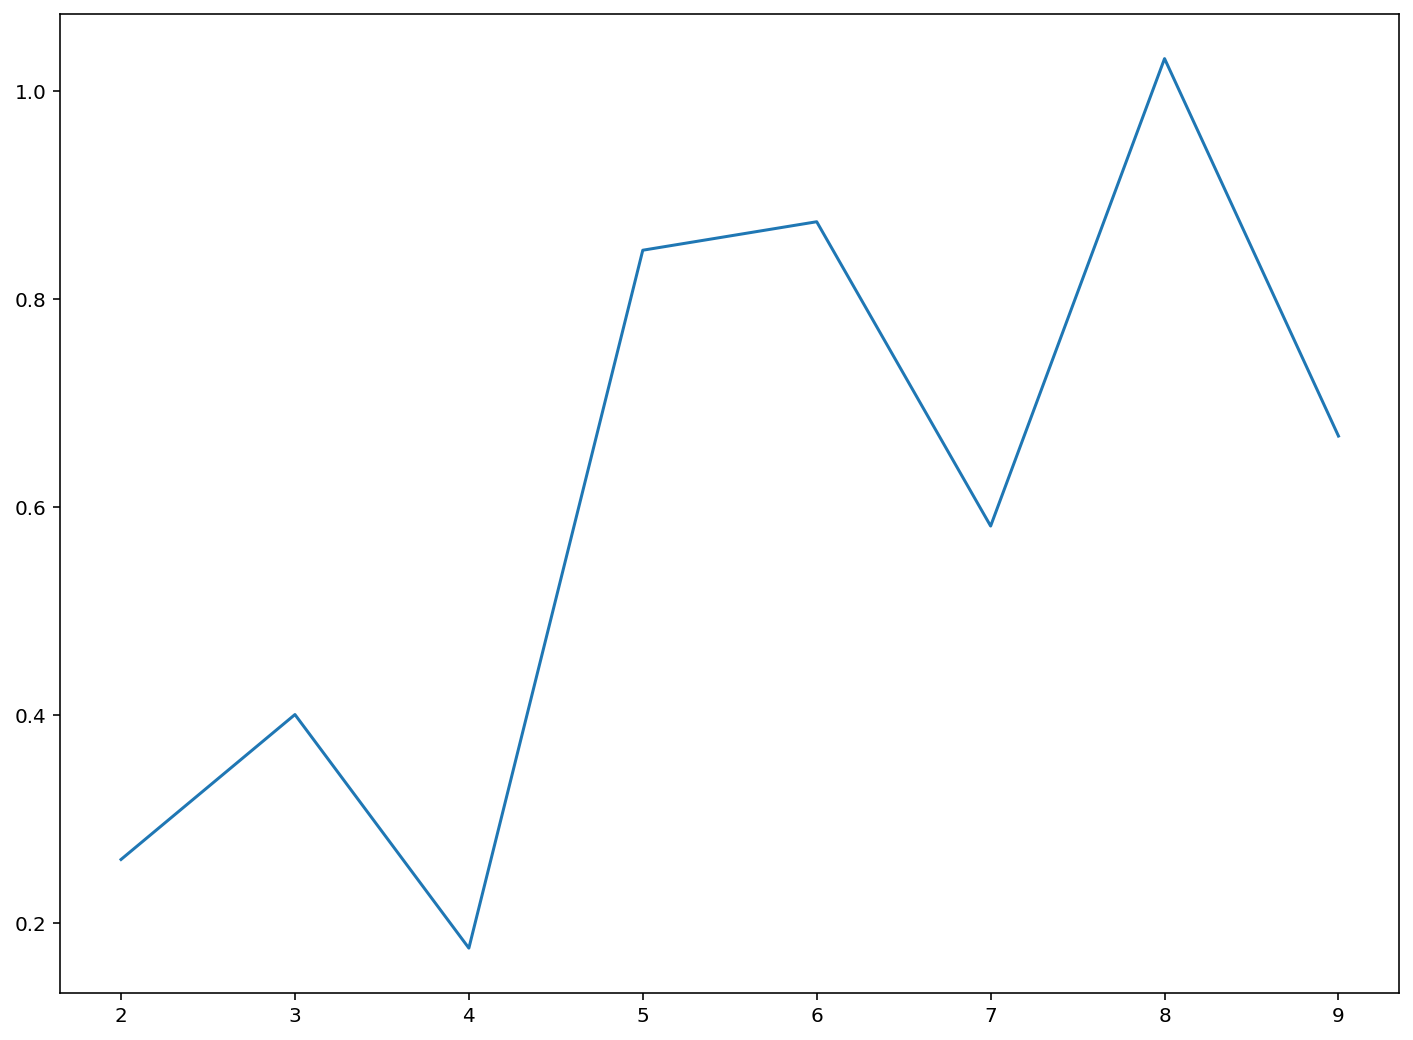

In [70]:
plt.plot(ks[1:-1], diff_r)

In [71]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

4

ну, вот мы и получили совершенно неожиданно с помощью метода локтя, что оптимальным числом клатеров можно считать 4

In [80]:
km = KMeans(n_clusters=4)
km.fit(data_clear)
clusters = km.predict(data_clear)


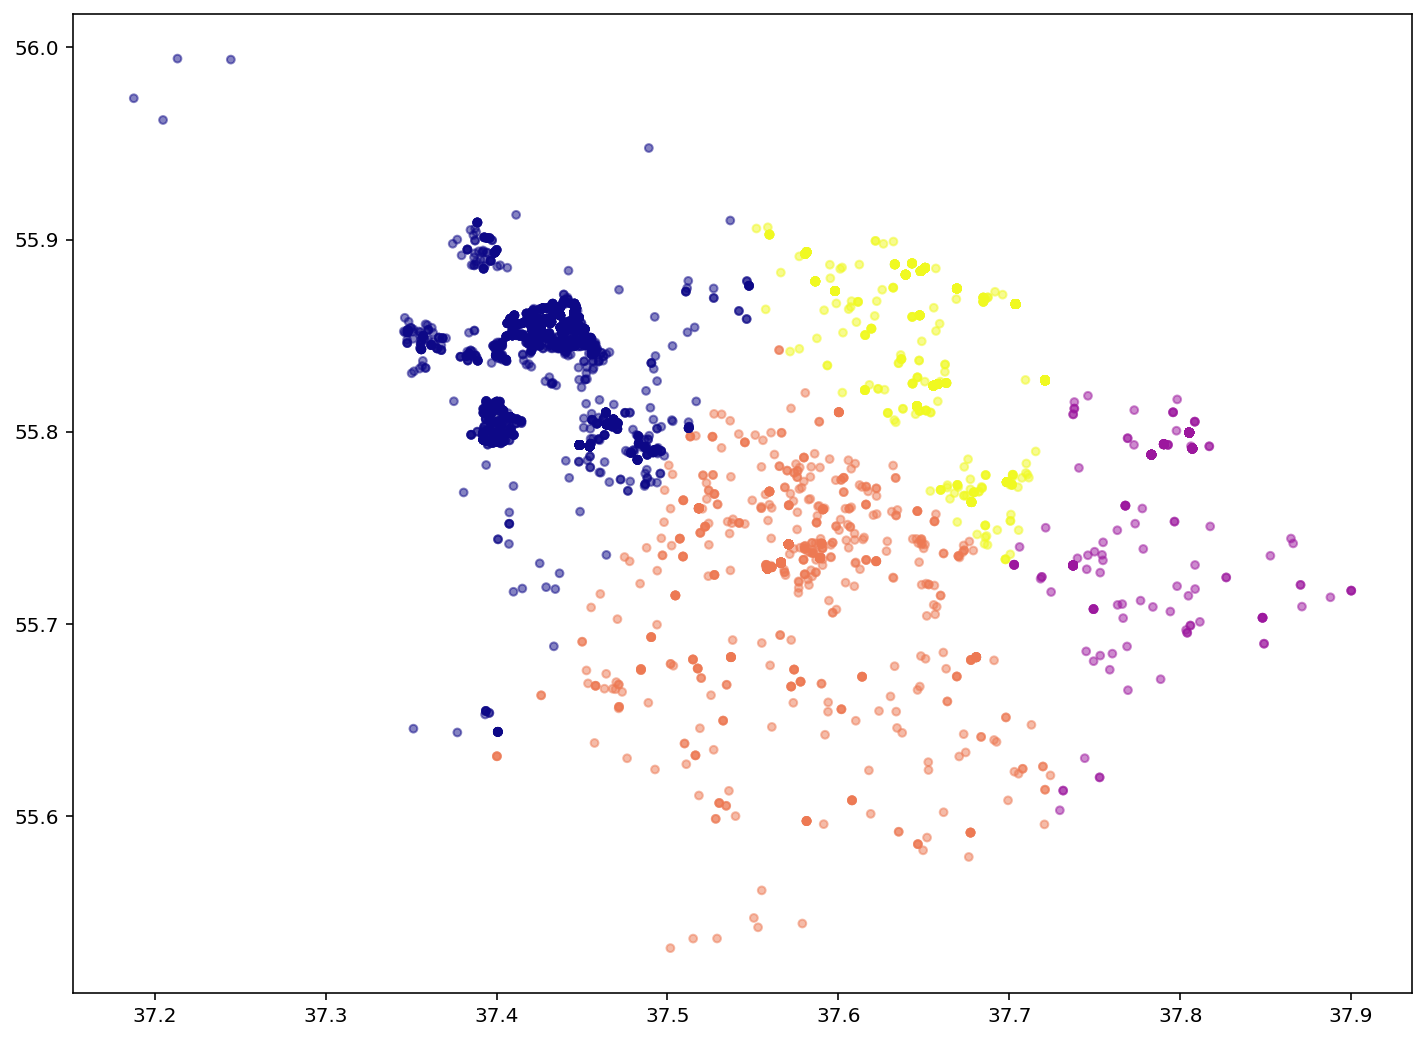

In [98]:
plt.scatter(data_clear.x, data_clear.y, c=clusters, cmap='plasma', s=15, alpha=0.5)

Только положительные голоса

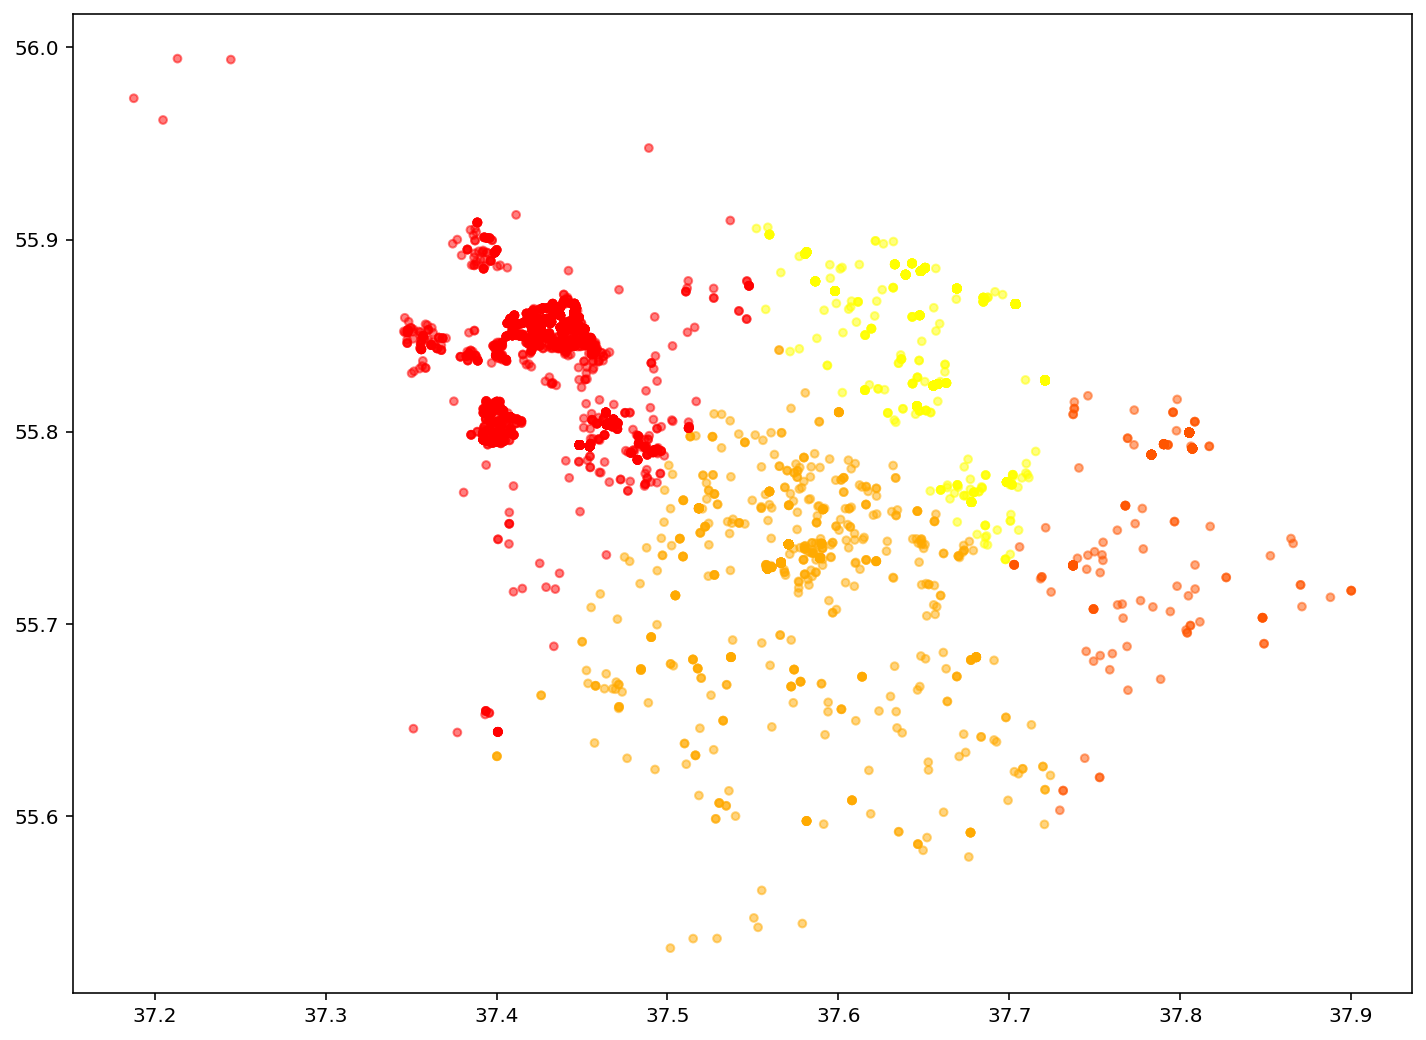

In [109]:
data_pc = data_p.drop('comment', axis=1)
km_p = KMeans(n_clusters=4)
km_p.fit(data_pc)
clusters_p = km.predict(data_pc)
plt.scatter(data_pc.x, data_pc.y, c=clusters_p, cmap='autumn', s=15, alpha=0.5)

Только отрицательные голоса:

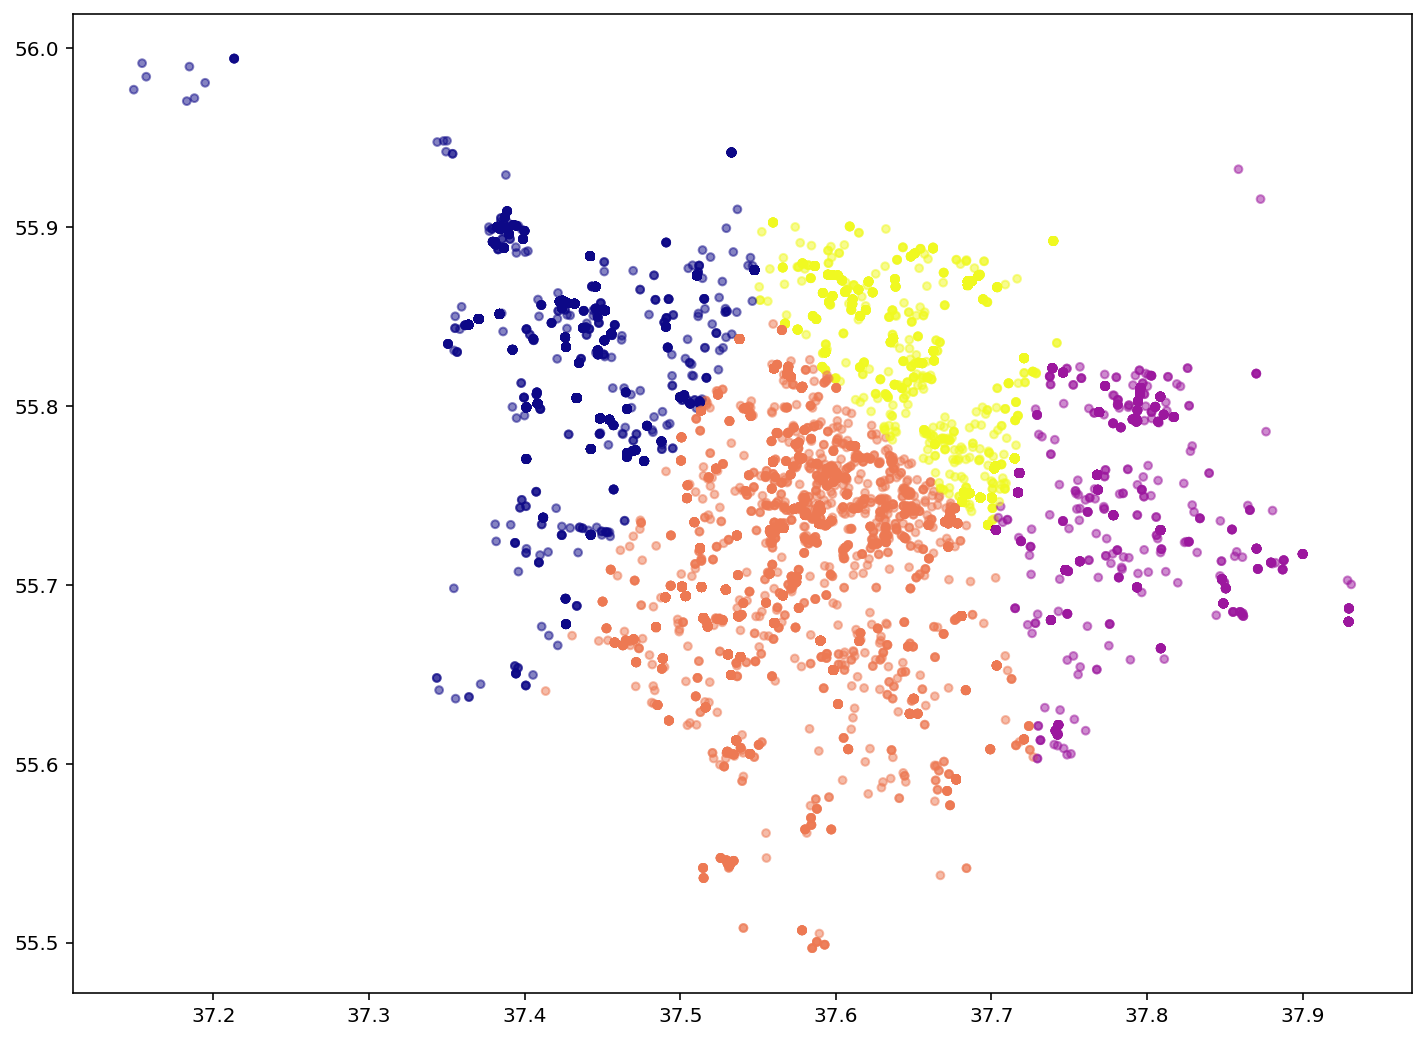

In [111]:
data_nc = data_n.drop('comment', axis=1)
km_n = KMeans(n_clusters=4)
km_n.fit(data_nc)
clusters_n = km.predict(data_nc)
plt.scatter(data_nc.x, data_nc.y, c=clusters_n, cmap='plasma', s=15, alpha=0.5)

Самые активные районы:

In [158]:
db_model = DBSCAN(eps=0.02, min_samples=300, n_jobs=-1 )# создаем модель и определяем плотность с помощью праметра min_samples

In [159]:
db_clusters = db_model.fit_predict(data_clear)# обучаем модель

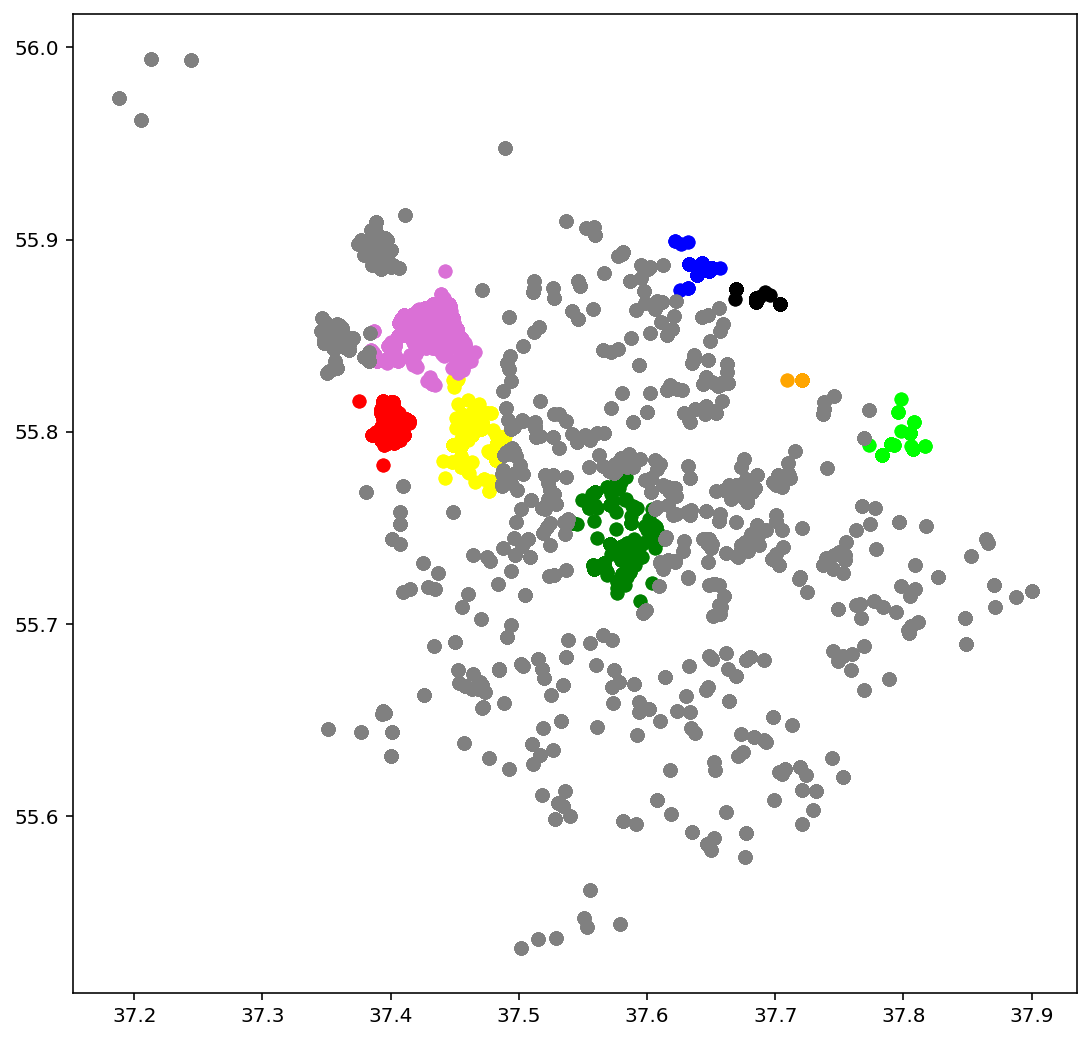

In [164]:
rcParams['figure.figsize'] = (9,9)
for i, color in zip(range(10),{'blue','red','green','black','orange','yellow','brown','orchid','lime'}):
    x_i = data_clear.x[db_clusters==i]
    y_i = data_clear.y[db_clusters==i]
    plt.plot(x_i, y_i, 'o', c=color)
    plt.plot(x_i, y_i, 'o', c=color)
    
    x_0 = data_clear.x[db_clusters==-1]
    y_0 = data_clear.y[db_clusters==-1]
    plt.plot(x_0, y_0, 'o', c='grey')


Поработаем с текстом

In [171]:
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

In [169]:
data_comments = data.drop(['x', 'y', 'comment_class', 'Unnamed: 0'], axis=1) #все голоса без лишних колонок
data_comments.head()

,multiplier,comment
0,1,Во все разделы правил землепользования и застр...
1,1,На основании вступившего в законную силу судеб...
2,1,Внести в Проект правил землепользования и заст...
3,1,Учитывая социальную значимость проекта строите...
4,1,Учитывая социальную значимость проекта строите...


In [172]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
PortSt = PorterStemmer()
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [173]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}

PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [176]:
clean_dict = {}
counter = 0

for number, doc in zip(range(10000), data_comments.comment):
    body = doc
    body = re.sub('\[.*?\]','', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # делаем стемминг и нормализацию
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                filtered_tokens = []
                filtered_tokens.append(word)
                for t in filtered_tokens:
                    stems = stemmer.stem(t)
                    tokens.append(stems)
        # убираем стоп слова
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # убираем слова маленькой длины
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 500 == 0:
        print("{0} комментариев обработано".format(counter))
    if counter == 10000: # для ускорения расчета берем выборку из 10 000
        break
    clean_dict[number] = tokens
#     clean_dict.append(tokens)

clean_dict = {key: list(val) for key, val in clean_dict.items()}

500 комментариев обработано
1000 комментариев обработано
1500 комментариев обработано
2000 комментариев обработано
2500 комментариев обработано
3000 комментариев обработано
3500 комментариев обработано
4000 комментариев обработано
4500 комментариев обработано
5000 комментариев обработано
5500 комментариев обработано
6000 комментариев обработано
6500 комментариев обработано
7000 комментариев обработано
7500 комментариев обработано
8000 комментариев обработано
8500 комментариев обработано
9000 комментариев обработано
9500 комментариев обработано
10000 комментариев обработано


ModuleNotFoundError: No module named 'gensim'

In [178]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [181]:
from gensim.corpora import TextCorpus
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=clean_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=8, passes=30
)

In [192]:
print('8 основных тематик (согласно обработке модели LdaModel):\n')
for i in range(8):
    terms = justlda.get_topic_terms(i)
    print(i+1,'-', ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

8 основных тематик (согласно обработке модели LdaModel):

1 - предусмотрен пункт устанавлива разрешен участник един исключа территориальн использован замечан
2 - высот развит площад застройк центр территор предельн плотност гараж погодинск
3 - октябр округ шосс планировк северн мост парк экологическ ленинградск целесообразн
4 - строительств район жител адрес прот проект территор застройк улиц здан
5 - участк земельн москв адрес проект застройк площад прав использован номер
6 - включа деятельн московск постановлен вход декабр однак главн работ образ
7 - учет подел имуществ габарит собственник назначен устанавлива квартал росс допущен
8 - территор москв предложен проект землепользован публичн слушан застройк соответств прав
